<a href="https://colab.research.google.com/github/BhekiMabheka/Explore/blob/main/Employee_Addmission.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Objective:**
- Train a model that would predict if a candidate will be hired

In [1]:
# Data Wrangling Packages
import pandas as pd
import numpy as np
import seaborn as sns
import plotly.express as px
import warnings
import matplotlib.pyplot as plt

# Machine Learning Packages
from sklearn.model_selection import train_test_split
from sklearn.linear_model import *
from sklearn.metrics import *
from sklearn.preprocessing import LabelEncoder
from sklearn.ensemble import *

from matplotlib.gridspec import GridSpec
from sklearn.calibration import CalibratedClassifierCV, CalibrationDisplay

template = 'plotly_dark'
warnings.filterwarnings("ignore")

In [2]:
admissions_df = pd.read_csv("https://raw.githubusercontent.com/BhekiMabheka/Data/master/admissions.csv")

In [3]:
# Num of obeservations and features
print("Num of rows and features: ", admissions_df.shape) 
admissions_df.head(1)

Num of rows and features:  (64722, 3)


,candidate_id,department,admit
0,933951,E,Rejected


In [4]:
candinates_df = pd.read_csv("https://raw.githubusercontent.com/BhekiMabheka/Data/master/candidates.csv")

In [5]:
# Num of obeservations and features
print("Num of rows and features: ", candinates_df.shape) 
candinates_df.head(3)

Num of rows and features:  (49786, 6)


,name,candidate_id,age,gender,no_children,emp_card_id
0,Geneva Le,928100,43.0,Female,NaN,7505.0
1,Marilyn Weber,913797,51.0,Male,0.0,NaN
2,Marlene Deweese,926775,30.0,Male,2.0,NaN


In [6]:
# Join admissions and candinates datasets
df  = pd.merge(left = admissions_df, left_on = ['candidate_id'], right = candinates_df, right_on = ['candidate_id'], how = 'inner')
print("Num of obeservations and features: ", df.shape)
df.head(3)

Num of obeservations and features:  (64722, 8)


,candidate_id,department,admit,name,age,gender,no_children,emp_card_id
0,933951,E,Rejected,Chester Joshua,43.0,Male,2.0,NaN
1,933951,E,Rejected,Chester Joshua,43.0,Male,2.0,NaN
2,910365,B,Admitted,Ralph Turner,44.0,Male,0.0,1010.0


In [7]:
# Check the unique entries on categorical features
def check_unique_entries(df):
    for col in df.select_dtypes(include=['bool', 'object']).columns.tolist():
        print(col," :",df[col].unique())
        
check_unique_entries(df)

department  : ['E' 'B' 'D' 'A' 'F' 'C']
admit  : ['Rejected' 'Admitted']
name  : ['Chester Joshua' 'Ralph Turner' 'Chelsea Muszynski' ... 'Maria Radford'
 'Mary Greggs' 'Justin Cook']
gender  : ['Male' 'Female']


In [8]:
def explore_df(df):   
    """
    A more advanced version of describe for tabular exploratory data analysis. Inlcudes additional information such as,
    missing observations, unique observations, constant feature flagging, all_missing feature flagging, feature types & outlier
    values.
    Parameters
    ----------
    df : pandas df, required, default=NA
        Pandas dataframe object 
    Returns
    -------
    pandas df
        Returns a pandas dataframe object
    
    Usage
    -----
        df = pd.DataFrame({"x1": ["a", "b", "c", "a"], "x2":['x','y','x','x'], "y": [1,1,0,1]})
        eda = explore_df(df=df)
    """
    import pandas as pd
    import numpy as np
    
    ft                     = pd.DataFrame()
    ft['type']             = df.dtypes.astype(str)
    ft['feature']          = ft.index
    ft['num_of_unique']    = df.nunique()
    ft['num_of_missing']   = df.isnull().sum()
    ft['num_of_missing_%'] = (df.isnull().sum()/ df.isnull().count()).round(2)
    
    numeric = ft.loc[(ft['type'].str.contains('float'))]['feature']
    numeric = numeric.append(ft.loc[(ft['type'].str.contains('int'))]['feature'])
    
    categorical = ft.loc[(ft['type'].str.contains('object'))]['feature']

    # Summary statistics
    lower=df[numeric].quantile(q=0.25)
    upper=df[numeric].quantile(q=0.75)
    ft['min']=df[numeric].min()
    ft['max']=df[numeric].max()
    ft['q1']=lower
    ft['median']=df[numeric].median()
    ft['mean']=df[numeric].mean()
    ft['q3']=upper
    
    # Caclulate outlier values
    iqr = upper - lower
    lower=lower-(1.5*iqr)
    upper=upper+(1.5*iqr)
    ft['lower_outlier']=lower
    ft['upper_outlier']=upper
    ft['skewness']=df[numeric].skew()
        
    ft=ft[['feature','type','num_of_missing','num_of_missing_%','num_of_unique','min','q1','median','mean','q3','max','lower_outlier',
           'upper_outlier','skewness']].reset_index(drop=True)

    return ft

explore_df(df)

,feature,type,num_of_missing,num_of_missing_%,num_of_unique,min,q1,median,mean,q3,max,lower_outlier,upper_outlier,skewness
0,candidate_id,int64,0,0.00,49786,896465.0,908888.0,921393.5,921365.843114,933816.75,9.462500e+05,871494.875,971209.875,-0.000859
1,department,object,0,0.00,6,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,admit,object,0,0.00,2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,name,object,0,0.00,47415,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,age,float64,0,0.00,59,11.0,33.0,39.0,66399.551111,46.00,2.147484e+09,13.500,65.500,179.887465
5,gender,object,0,0.00,2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6,no_children,float64,9552,0.15,5,0.0,0.0,1.0,1.052075,2.00,4.000000e+00,-3.000,5.000,0.201209
7,emp_card_id,float64,42124,0.65,8276,0.0,2506.0,5054.5,5011.285866,7516.00,9.999000e+03,-5009.000,15031.000,-0.014461


---
#### Comments on `data quality`.

- Out of 64 722 candinates 65%(42 124) don't have `employee card id` and it looks there's some un-trusted entries since the max_value it's 9999
- Out of 64 722 candinates 15% don't have children or their number of children it's not captured/reported. So from Machine Learning perspective it won't be safe to impute the missings values with zero. In other words having to impute with zero, an employee might lose certain benefits. We rather investigate or delete the entries!
- It looks like we do have outlier on a feature `age`, no one can live up to this `2147483647`
- Again of the feature `age` we cannot compute an average with outliers-this means lower and upper outliers should be handled.
- It's interesting how can a candinate start to work/apply at the `age of 11` - this sounds like a child labour!
- There's about six departments


----


In [9]:
def remove_outlier(df, col_name):
    
    q1 = df[col_name].quantile(0.25)
    q3 = df[col_name].quantile(0.75)
    iqr = q3-q1 #Interquartile range
    fence_low  = q1-1.5*iqr
    fence_high = q3+1.5*iqr
    df_with_no_outliers = df.loc[(df[col_name] > fence_low) & (df[col_name] < fence_high)]
    
    return df_with_no_outliers

In [10]:
df = remove_outlier(df = df, col_name = 'age')
df = remove_outlier(df = df, col_name = 'no_children')

In [11]:
df[['age','no_children']].describe()

,age,no_children
count,55150.000000,55150.000000
mean,38.720381,1.052094
std,9.012535,0.885095
min,14.000000,0.000000
25%,32.000000,0.000000
50%,39.000000,1.000000
75%,45.000000,2.000000
max,65.000000,4.000000


In [12]:
fig = px.histogram(df, x='age', marginal='box', color = 'admit', template=template)
fig.show()

- The feature `age` follows a gussian distributions, which is good for most ML algorithms
- The company seems to employ older employee

----

In [13]:
fig = px.histogram(df, x='no_children', marginal='box', color = 'admit',barmode = "group", template=template)
fig.update_layout(xaxis={'categoryorder':'category ascending'})
fig.show()

- The feature `age` follows a gussian distributions, which is good for most ML algorithms
- The company seems to employ older employee

----

In [14]:
fig = px.histogram(df, x="department",color='admit', barmode='group',height=400,histfunc="count",template=template)
fig.update_layout(xaxis={'categoryorder':'category ascending'})
fig.show()

- Department F have more rejections with less hiring throughout the all the departments. This needs to be investigated, why so many applications but less hiring! 
- Department A admit more candinates.

---

In [15]:
admission_by_department = df.groupby(['gender', 'admit', 'department'])['age'].describe()

In [16]:
def check_teens(series):
    red    = 'background-color: red;'
    default      = ''
    return [red if e < 30 else default for e in series]

def check_old_age(series):
    orange     = "background-color: orange;"
    default = ''
    return [orange if e > 50 else default for e in series]

def maximum_value_in_column(column):    
    highlight = 'background-color: palegreen;'
    default = ''
    maximum_in_column = column.max()
    minimum_in_column = column.min()
    
    return [highlight if v == maximum_in_column else highlight if v == minimum_in_column else default for v in column]

admission_by_department.style\
                       .apply(check_teens, axis=0, subset=['mean','min'])\
                       .apply(check_old_age, axis=0, subset=['mean','max','75%'])\
                       .apply(maximum_value_in_column, axis=0, subset=['mean','count'])

- Looks like a company prefer to hire/retain older men in department A
- It's interesting that they're young ladies(teens) who're trying to apply but their getting rejection, there's one teenage who got addmitted. Question is now what's so special about this one lady

- There's no even a single male teenage who got admitted!

By this virtue to some extend the company does discriminate...howver a term discriminate needs to be supported by other factors such race, salary,education etc which we don't have on this data! 

----

In [17]:
fig = px.histogram(df, x="gender",color='admit', barmode='group',height=400,histfunc="count",template=template)
fig.update_layout(xaxis={'categoryorder':'category ascending'})
fig.show()

- It's quite clear the company do admit most male and some of these male candinates are above 50!
---

# Modelling

#### Examine classes and class imbalance
​
Class imbalance means that there are unequal numbers of cases for the categories of the label. Class imbalance can seriously bias the training of classifier algorithms. It many cases, the imbalance leads to a higher error rate for the minority class. Most real-world classification problems have class imbalance, sometimes severe class imbalance, so it is important to test for this before training any model.
​
Class imbalance can be sovled by various sampling techniques such as [stratified sampling](https://en.wikipedia.org/wiki/Stratified_sampling), [Synthetic Minority Over-sampling](https://https://imbalanced-learn.readthedocs.io/en/stable/generated/imblearn.over_sampling.SMOTE.html#r001eabbe5dd7-1), [SVMSMOTE](https://imbalanced-learn.readthedocs.io/en/stable/generated/imblearn.over_sampling.SVMSMOTE.html#imblearn.over_sampling.SVMSMOTE) etc. Imbalance have a big impact on the model metric evaluation; more especially if you're trying to optimize accuracy!

In [18]:
print(np.round(df.admit.value_counts(normalize=True), 2))
targe_label_propotion = df.groupby('admit')[['admit']].count()

fig = px.bar(targe_label_propotion, template = template, text = 'value')
fig.update_traces(texttemplate = '%{text:.d}', textposition = 'inside')
fig.update_layout(uniformtext_minsize = 10, uniformtext_mode = 'hide')
fig.show()

Rejected    0.64
Admitted    0.36
Name: admit, dtype: float64


In [19]:
# Enconde gender and department
cols = ['gender', 'department']
df[cols] = df[cols].apply(LabelEncoder().fit_transform) 

In [20]:
X = df.drop(columns = ['candidate_id','admit','name','emp_card_id'])
y = df.admit

In [21]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=1, test_size = .2, stratify = y, shuffle = True)

print("X_train shape ", X_train.shape)
print("y_train       ", y_train.shape, "\n")
print("X_test shape  ",  X_test.shape)
print("y_test        ", y_test.shape)

X_train shape  (44120, 4)
y_train        (44120,) 

X_test shape   (11030, 4)
y_test         (11030,)


In [22]:
# Models
lr         = LogisticRegression(class_weight = 'balanced')
rnd_forest = RandomForestClassifier(class_weight = 'balanced')

In [23]:
def get_classification_report(y_true, y_pred):
    class_report = classification_report(y_true, y_pred)
    
    return print(class_report)                             

In [24]:
def testing_classification_report(y_pred, clf):
    #print(clf.__class__.__name__)
    print("".format(get_classification_report(y_test, y_pred)))
    print("-----------------------------------------------------------")

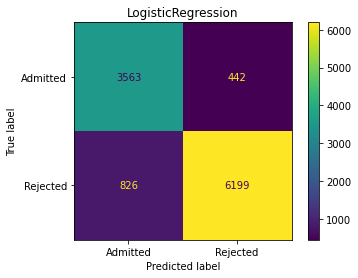

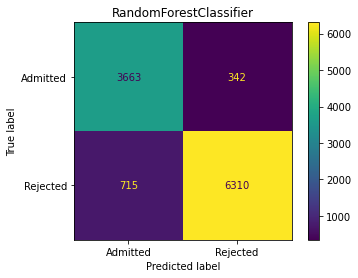

In [25]:
# Get the Confusion Matrix for each model
for classifier in [lr,rnd_forest]:
    clf = classifier
    clf.fit(X_train, y_train)
    
    disp = plot_confusion_matrix(estimator = clf, X = X_test, y_true = y_test)
    disp.ax_.set_title(clf.__class__.__name__)

- The model is quite balanced/able to classify the admission properly, because we have more values on *`True Positives and False True Negatives`*
----

In [26]:
# Classification Report on testing data sets
for classifier in [lr,rnd_forest]:
    clf = classifier
    clf.fit(X_train, y_train)
    
    y_pred_test = clf.predict(X_test)
    print('Testing Data: ',clf.__class__.__name__, '\n')
    testing_classification_report(y_pred_test, classifier)    

Testing Data:  LogisticRegression 

              precision    recall  f1-score   support

    Admitted       0.81      0.89      0.85      4005
    Rejected       0.93      0.88      0.91      7025

    accuracy                           0.89     11030
   macro avg       0.87      0.89      0.88     11030
weighted avg       0.89      0.89      0.89     11030


-----------------------------------------------------------
Testing Data:  RandomForestClassifier 

              precision    recall  f1-score   support

    Admitted       0.84      0.91      0.88      4005
    Rejected       0.95      0.90      0.92      7025

    accuracy                           0.91     11030
   macro avg       0.89      0.91      0.90     11030
weighted avg       0.91      0.91      0.91     11030


-----------------------------------------------------------


- The `f1_score(s)` for both models it's not bad-however since `Random Forest` it's more accurate I will opt for it 
- At this stage there's no need for parameter tunnning!
---

## Calibration curves

In [27]:
rnd_forest_isotonic = CalibratedClassifierCV(rnd_forest, cv=2, method="isotonic")
rnd_forest_sigmoid = CalibratedClassifierCV(rnd_forest, cv=2, method="sigmoid")

clf_list = [(lr, "Logistic"),(rnd_forest, "Random Forest"),
            (rnd_forest_isotonic, "Random Forest + Isotonic"),
            (rnd_forest_sigmoid, "Random Forest + Sigmoid")]

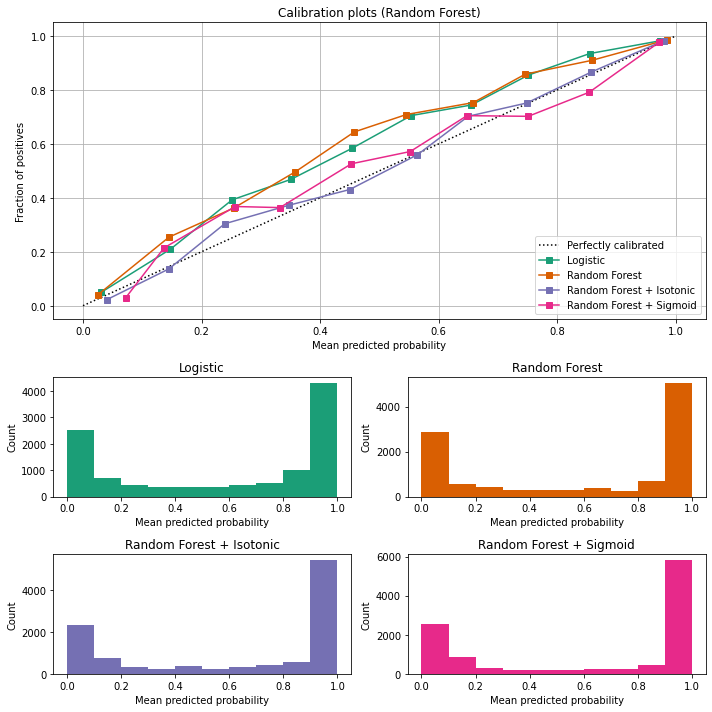

In [28]:
fig = plt.figure(figsize=(10, 10))
gs = GridSpec(4, 2)
colors = plt.cm.get_cmap("Dark2")

ax_calibration_curve = fig.add_subplot(gs[:2, :2])
calibration_displays = {}
for i, (clf, name) in enumerate(clf_list):
    clf.fit(X_train, y_train)
    display = CalibrationDisplay.from_estimator(clf, X_test, y_test, n_bins = 10, name = name,
                                                ax = ax_calibration_curve,color=colors(i))
    calibration_displays[name] = display

ax_calibration_curve.grid()
ax_calibration_curve.set_title("Calibration plots (Random Forest)");

# Add histogram
grid_positions = [(2, 0), (2, 1), (3, 0), (3, 1)]
for i, (_, name) in enumerate(clf_list):
    row, col = grid_positions[i]
    ax = fig.add_subplot(gs[row, col])

    ax.hist(calibration_displays[name].y_prob,range=(0, 1),bins=10,label=name,color=colors(i))
    ax.set(title=name, xlabel="Mean predicted probability", ylabel="Count");
plt.tight_layout()

In [29]:
def get_all_probabilities(df):
    """This function can be used in scoring dataset at the later stage to get probabilites for addmission status parameters"""
    all_predict_probas = rnd_forest.predict_proba(X)
    predictions        = rnd_forest.predict(X)
    probs = pd.DataFrame(data = all_predict_probas, columns = ["admitted_probability","rejected_probability"])
    
    return probs.round(3)

In [30]:
model_output = pd.concat([df, get_all_probabilities(df)],axis=1)
model_output = model_output[['candidate_id','emp_card_id','department', 'name','gender',
                             'age','no_children','admit','admitted_probability','rejected_probability']]
model_output.head()

,candidate_id,emp_card_id,department,name,gender,age,no_children,admit,admitted_probability,rejected_probability
0,933951.0,NaN,4.0,Chester Joshua,1.0,43.0,2.0,Rejected,0.099,0.901
1,933951.0,NaN,4.0,Chester Joshua,1.0,43.0,2.0,Rejected,0.099,0.901
2,910365.0,1010.0,1.0,Ralph Turner,1.0,44.0,0.0,Admitted,0.750,0.250
3,927783.0,NaN,3.0,Chelsea Muszynski,1.0,48.0,1.0,Rejected,0.783,0.217
4,927783.0,NaN,3.0,Chelsea Muszynski,1.0,48.0,1.0,Rejected,0.783,0.217


## Thank You:

---

